# Data Wrangling with Spark
This is the code used in the previous screencast. Run each code cell to understand what the code does and how it works.

These first three cells import libraries, instantiate a SparkSession, and then read in the data set

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

In [26]:
path = "C:\\Users\\arunk01\\Desktop\\Udacity\\data\*.json"
user_log = spark.read.json(path)

# Data Exploration¶
The next cells explore the data set.

In [28]:
user_log.take(5)

[Row(artist='Harmonia', auth='Logged In', firstName='Ryan', gender='M', itemInSession=0, lastName='Smith', length=655.77751, level='free', location='San Jose-Sunnyvale-Santa Clara, CA', method='PUT', page='NextSong', registration=1541016707796.0, sessionId=583, song='Sehr kosmisch', status=200, ts=1542241826796, userAgent='"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/36.0.1985.125 Chrome/36.0.1985.125 Safari/537.36"', userId='26'),
 Row(artist='The Prodigy', auth='Logged In', firstName='Ryan', gender='M', itemInSession=1, lastName='Smith', length=260.07465, level='free', location='San Jose-Sunnyvale-Santa Clara, CA', method='PUT', page='NextSong', registration=1541016707796.0, sessionId=583, song='The Big Gundown', status=200, ts=1542242481796, userAgent='"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/36.0.1985.125 Chrome/36.0.1985.125 Safari/537.36"', userId='26'),
 Row(artist='Train', auth='Logged In'

In [29]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: double (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [30]:
user_log.describe().show()

+-------+------------------+----------+---------+------+-----------------+--------+------------------+-----+--------------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|            artist|      auth|firstName|gender|    itemInSession|lastName|            length|level|            location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+----------+---------+------+-----------------+--------+------------------+-----+--------------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|              7176|      8464|     8171|  8171|             8464|    8171|              7176| 8464|                8171|  8464|   8464| 

In [31]:
user_log.describe("artist").show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|              7176|
|   mean|272.85714285714283|
| stddev|100.91651429346368|
|    min|               !!!|
|    max|   ÃÂtienne Daho|
+-------+------------------+



In [32]:
user_log.describe("sessionId").show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|             8464|
|   mean|578.8761814744802|
| stddev| 291.761723016622|
|    min|                3|
|    max|             1114|
+-------+-----------------+



In [33]:
user_log.count()

8464

In [34]:
user_log.select("page").dropDuplicates().sort("page").show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [37]:
user_log.describe("userId").show()

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|              8464|
|   mean|  54.5869538612165|
| stddev|28.104005493151167|
|    min|                  |
|    max|                99|
+-------+------------------+



In [41]:
user_log.select(["userId", "firstname", "page", "song"]).where(user_log.userId == "100").collect()

[Row(userId='100', firstname='Adler', page='NextSong', song='Politik'),
 Row(userId='100', firstname='Adler', page='NextSong', song='New Divide (Album Version)'),
 Row(userId='100', firstname='Adler', page='NextSong', song='Bloodletting (The Vampire Song)'),
 Row(userId='100', firstname='Adler', page='Home', song=None),
 Row(userId='100', firstname='Adler', page='NextSong', song='Catch You Baby (Steve Pitron & Max Sanna Radio Edit)'),
 Row(userId='100', firstname='Adler', page='NextSong', song='Bleed It Out (Album Version)'),
 Row(userId='100', firstname='Adler', page='Home', song=None),
 Row(userId='100', firstname='Adler', page='Home', song=None),
 Row(userId='100', firstname='Adler', page='NextSong', song='Traded In My Cigarettes'),
 Row(userId='100', firstname='Adler', page='NextSong', song='Talk Is Drastik'),
 Row(userId='100', firstname='Adler', page='NextSong', song='EMCEE Murdah'),
 Row(userId='100', firstname='Adler', page='NextSong', song='Come Undone'),
 Row(userId='100', fi

# Calculating Statistics by Hour

In [44]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [45]:
user_log = user_log.withColumn("hour", get_hour(user_log.ts))

In [46]:
user_log.head()

Row(artist='Harmonia', auth='Logged In', firstName='Ryan', gender='M', itemInSession=0, lastName='Smith', length=655.77751, level='free', location='San Jose-Sunnyvale-Santa Clara, CA', method='PUT', page='NextSong', registration=1541016707796.0, sessionId=583, song='Sehr kosmisch', status=200, ts=1542241826796, userAgent='"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/36.0.1985.125 Chrome/36.0.1985.125 Safari/537.36"', userId='26', hour='18')

In [47]:
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [48]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  173|
|   1|  197|
|   2|  214|
|   3|  281|
|   4|  348|
|   5|  348|
|   6|  334|
|   7|  346|
|   8|  466|
|   9|  505|
|  10|  562|
|  11|  535|
|  12|  542|
|  13|  387|
|  14|  368|
|  15|  274|
|  16|  229|
|  17|  201|
|  18|  157|
|  19|  158|
+----+-----+
only showing top 20 rows



In [49]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

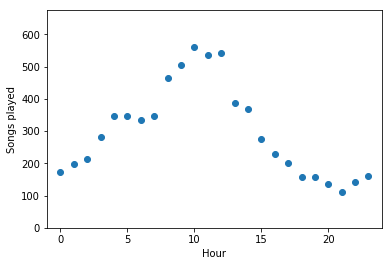

In [50]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

# Drop Rows with Missing Values
As you'll see, it turns out there are no missing values in the userID or session columns. But there are userID values that are empty strings.

In [51]:
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

In [52]:
user_log_valid.count()

8464

In [53]:
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|   101|
|    11|
|    12|
|    13|
|    14|
|    15|
|    16|
|    17|
|    18|
|    19|
|     2|
|    20|
|    21|
|    22|
|    23|
|    24|
|    25|
+------+
only showing top 20 rows



In [55]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [56]:
user_log_valid.count()

8171

# Users Downgrade Their Accounts
Find when users downgrade their accounts and then flag those log entries. Then use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.

In [57]:
user_log_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-----------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page|     registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-----------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|     Lily|     F|           23|    Koch|  null| paid|Chicago-Napervill...|   PUT|Submit Downgrade|1.541048010796E12|      764|null|   307|1542798517796|"Mozilla/5.0 (X11...|    15|   5|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-----------------+---------+----+------+-------------+--------------

In [67]:
user_log.select(["userId", "firstname", "page", "level", "song"]).where(user_log.userId == "15").collect()

[Row(userId='15', firstname='Lily', page='NextSong', level='paid', song='Black Hole Sun'),
 Row(userId='15', firstname='Lily', page='NextSong', level='paid', song='Addicted'),
 Row(userId='15', firstname='Lily', page='NextSong', level='paid', song='Air'),
 Row(userId='15', firstname='Lily', page='NextSong', level='paid', song='Superbeast'),
 Row(userId='15', firstname='Lily', page='NextSong', level='paid', song='I Remember'),
 Row(userId='15', firstname='Lily', page='NextSong', level='paid', song="You're The One"),
 Row(userId='15', firstname='Lily', page='NextSong', level='paid', song='Fool'),
 Row(userId='15', firstname='Lily', page='NextSong', level='paid', song='Marguerite'),
 Row(userId='15', firstname='Lily', page='NextSong', level='paid', song='Brothers'),
 Row(userId='15', firstname='Lily', page='NextSong', level='paid', song='My Own Worst Enemy'),
 Row(userId='15', firstname='Lily', page='NextSong', level='paid', song='Time To Pretend'),
 Row(userId='15', firstname='Lily', pag

In [68]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [69]:
user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [70]:
user_log_valid.head()

Row(artist='Harmonia', auth='Logged In', firstName='Ryan', gender='M', itemInSession=0, lastName='Smith', length=655.77751, level='free', location='San Jose-Sunnyvale-Santa Clara, CA', method='PUT', page='NextSong', registration=1541016707796.0, sessionId=583, song='Sehr kosmisch', status=200, ts=1542241826796, userAgent='"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/36.0.1985.125 Chrome/36.0.1985.125 Safari/537.36"', userId='26', hour='18', downgraded=0)

In [71]:
from pyspark.sql import Window

In [72]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [73]:
user_log_valid = user_log_valid.withColumn("phase", Fsum("downgraded").over(windowval))

In [74]:
user_log_valid.select(["userId", "firstname", "ts", "page", "level", "phase"]).where(user_log.userId == "15").sort("ts").collect()

[Row(userId='15', firstname='Lily', ts=1541149281796, page='NextSong', level='paid', phase=1),
 Row(userId='15', firstname='Lily', ts=1541149456796, page='NextSong', level='paid', phase=1),
 Row(userId='15', firstname='Lily', ts=1541149698796, page='NextSong', level='paid', phase=1),
 Row(userId='15', firstname='Lily', ts=1541149952796, page='NextSong', level='paid', phase=1),
 Row(userId='15', firstname='Lily', ts=1541150176796, page='NextSong', level='paid', phase=1),
 Row(userId='15', firstname='Lily', ts=1541150355796, page='NextSong', level='paid', phase=1),
 Row(userId='15', firstname='Lily', ts=1541150563796, page='NextSong', level='paid', phase=1),
 Row(userId='15', firstname='Lily', ts=1541150809796, page='NextSong', level='paid', phase=1),
 Row(userId='15', firstname='Lily', ts=1541151060796, page='NextSong', level='paid', phase=1),
 Row(userId='15', firstname='Lily', ts=1541151325796, page='NextSong', level='paid', phase=1),
 Row(userId='15', firstname='Lily', ts=15411516117

In [85]:
user_log_gender = user_log.select(["userId", "firstname", "page", "song"]).where(user_log.gender == "F").dropDuplicates()

In [86]:
user_log_gender.count()

4853

In [87]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

In [88]:
# 1) import any other libraries you might need
# 2) instantiate a Spark session 
# 3) read in the data set located at the path "data/sparkify_log_small.json"
# 4) write code to answer the quiz questions 

spark = SparkSession \
    .builder \
    .appName("Data Frames practice") \
    .getOrCreate()

df = spark.read.json("C:\\Users\\arunk01\\Desktop\\Udacity\\data\*.json")

# Question 1
Which page did user id "" (empty string) NOT visit?

In [89]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: double (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [90]:
# filter for users with blank user id
blank_pages = df.filter(df.userId == '') \
    .select(col('page') \
    .alias('blank_pages')) \
    .dropDuplicates()

# get a list of possible pages that could be visited
all_pages = df.select('page').dropDuplicates()

# find values in all_pages that are not in blank_pages
# these are the pages that the blank user did not go to
for row in set(all_pages.collect()) - set(blank_pages.collect()):
    print(row.page)

Downgrade
Submit Upgrade
Submit Downgrade
NextSong
Settings
Logout
Save Settings
Upgrade
Error


# Question 2 - Reflect
What type of user does the empty string user id most likely refer to?

Perhaps it represents users who have not signed up yet or who are signed out and are about to log in.

# Question 3
How many female users do we have in the data set?

In [91]:
df.filter(df.gender == 'F') \
    .select('userId', 'gender') \
    .dropDuplicates() \
    .count()

55

# Question 4
How many songs were played from the most played artist?

In [92]:
df.filter(df.page == 'NextSong') \
    .select('Artist') \
    .groupBy('Artist') \
    .agg({'Artist':'count'}) \
    .withColumnRenamed('count(Artist)', 'Artistcount') \
    .sort(desc('Artistcount')) \
    .show(1)

+--------+-----------+
|  Artist|Artistcount|
+--------+-----------+
|Coldplay|         62|
+--------+-----------+
only showing top 1 row



# Question 5 (challenge)
How many songs do users listen to on average between visiting our home page? Please round your answer to the closest integer.

In [93]:
# TODO: filter out 0 sum and max sum to get more exact answer

function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = df.filter((df.page == 'NextSong') | (df.page == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', function(col('page'))) \
    .withColumn('period', Fsum('homevisit').over(user_window))

cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).show()

+------------------+
|avg(count(period))|
+------------------+
| 12.04026845637584|
+------------------+

